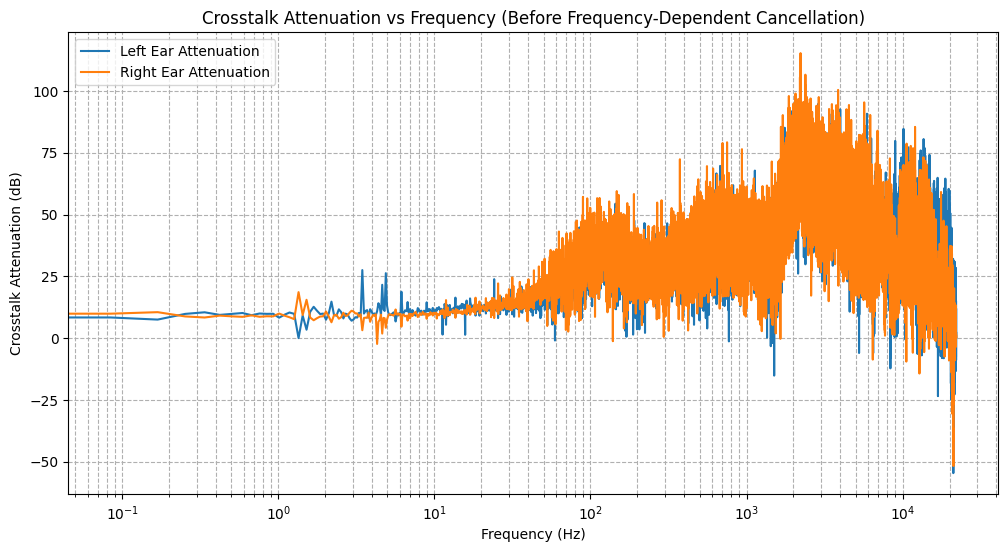

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import soundfile as sf

def read_hrtf(filename):
    data, _ = sf.read(filename)
    return data

H_LL = read_hrtf("/content/drive/MyDrive/XTC Audio/L0e330a.wav")  # Left speaker to left ear
H_LR = read_hrtf("/content/drive/MyDrive/XTC Audio/L0e030a.wav")  # Right speaker to left ear
H_RL = read_hrtf("/content/drive/MyDrive/XTC Audio/R0e330a.wav")  # Left speaker to right ear
H_RR = read_hrtf("/content/drive/MyDrive/XTC Audio/R0e030a.wav")  # Right speaker to right ear

signal, fs = sf.read("/content/drive/MyDrive/XTC Audio/binaural test file.wav")
L_desired = signal[:, 0]
R_desired = signal[:, 1]

# Adjust N to be a suitable power of two
def next_power_of_2(x):
    return 1 << (x - 1).bit_length()

N = next_power_of_2(len(L_desired) + len(H_LL) - 1)

epsilon = 1e-10  # Small value to prevent division by zero

# Compute FFTs of HRTFs padded to length N
H_LL_f = np.fft.fft(H_LL, n=N)
H_LR_f = np.fft.fft(H_LR, n=N)
H_RL_f = np.fft.fft(H_RL, n=N)
H_RR_f = np.fft.fft(H_RR, n=N)

# Compute FFTs of the desired ear signals padded to length N
L_f = np.fft.fft(L_desired, n=N)
R_f = np.fft.fft(R_desired, n=N)

# Stack HRTFs into arrays (shape: N x 2 x 2)
H_f = np.zeros((N, 2, 2), dtype=complex)
H_f[:, 0, 0] = H_LL_f
H_f[:, 0, 1] = H_LR_f
H_f[:, 1, 0] = H_RL_f
H_f[:, 1, 1] = H_RR_f

# Regularization
delta = 1e-2

H_f_reg = H_f.copy()
H_f_reg[:, 0, 0] += delta
H_f_reg[:, 1, 1] += delta

# Compute inverse of H matrices at each frequency bin
Inv_H_f = np.zeros_like(H_f_reg)
det_H_f = (H_f_reg[:, 0, 0] * H_f_reg[:, 1, 1] - H_f_reg[:, 0, 1] * H_f_reg[:, 1, 0]) + epsilon

Inv_H_f[:, 0, 0] = H_f_reg[:, 1, 1] / det_H_f
Inv_H_f[:, 0, 1] = -H_f_reg[:, 0, 1] / det_H_f
Inv_H_f[:, 1, 0] = -H_f_reg[:, 1, 0] / det_H_f
Inv_H_f[:, 1, 1] = H_f_reg[:, 0, 0] / det_H_f

# Stack desired ear signals (shape: N x 2)
Desired_f = np.stack((L_f, R_f), axis=1)

# Compute loudspeaker signals in frequency domain
S_f = np.einsum('nij,nj->ni', Inv_H_f, Desired_f)

# Compute inverse FFT to get time-domain loudspeaker signals
S_L = np.fft.ifft(S_f[:, 0]).real[:len(L_desired)]
S_R = np.fft.ifft(S_f[:, 1]).real[:len(R_desired)]

def simulate_ear_signals_freq(S_L_f, S_R_f, H_LL_f, H_LR_f, H_RL_f, H_RR_f):
    # Compute ear signals in frequency domain
    Ear_L_f = H_LL_f * S_L_f + H_LR_f * S_R_f
    Ear_R_f = H_RL_f * S_L_f + H_RR_f * S_R_f
    return Ear_L_f, Ear_R_f

def simulate_ear_signals_no_cancellation_freq(L_desired_f, R_desired_f, H_LL_f, H_LR_f, H_RL_f, H_RR_f):
    # Ear signals without crosstalk cancellation
    Ear_L_before_f = H_LL_f * L_desired_f + H_LR_f * R_desired_f
    Ear_R_before_f = H_RL_f * L_desired_f + H_RR_f * R_desired_f
    return Ear_L_before_f, Ear_R_before_f

# Compute crosstalk levels in frequency domain
def compute_crosstalk_levels_freq(Ear_L_f, Ear_R_f, L_desired_f, R_desired_f):

    Desired_L_f = L_desired_f
    Desired_R_f = R_desired_f

    Crosstalk_L_f = Ear_L_f - Desired_L_f
    Crosstalk_R_f = Ear_R_f - Desired_R_f

    # Compute power spectral densities
    PSD_Desired_L = np.abs(Desired_L_f) ** 2
    PSD_Crosstalk_L = np.abs(Crosstalk_L_f) ** 2

    PSD_Desired_R = np.abs(Desired_R_f) ** 2
    PSD_Crosstalk_R = np.abs(Crosstalk_R_f) ** 2

    # Compute crosstalk ratios in dB
    CTR_L = 10 * np.log10(PSD_Crosstalk_L / (PSD_Desired_L + epsilon) + epsilon)
    CTR_R = 10 * np.log10(PSD_Crosstalk_R / (PSD_Desired_R + epsilon) + epsilon)

    return CTR_L, CTR_R

Ear_L_before_f, Ear_R_before_f = simulate_ear_signals_no_cancellation_freq(L_f, R_f, H_LL_f, H_LR_f, H_RL_f, H_RR_f)

CTR_L_before_freq, CTR_R_before_freq = compute_crosstalk_levels_freq(Ear_L_before_f, Ear_R_before_f, L_f, R_f)

Ear_L_after_f, Ear_R_after_f = simulate_ear_signals_freq(S_f[:, 0], S_f[:, 1], H_LL_f, H_LR_f, H_RL_f, H_RR_f)

CTR_L_after_freq, CTR_R_after_freq = compute_crosstalk_levels_freq(Ear_L_after_f, Ear_R_after_f, L_f, R_f)

Crosstalk_Attenuation_L_freq = CTR_L_before_freq - CTR_L_after_freq
Crosstalk_Attenuation_R_freq = CTR_R_before_freq - CTR_R_after_freq

# Frequency vector
freqs = np.fft.fftfreq(N, d=1/fs)

# Only consider positive frequencies
positive_freqs = freqs[:N//2]
Attenuation_L_positive = Crosstalk_Attenuation_L_freq[:N//2]
Attenuation_R_positive = Crosstalk_Attenuation_R_freq[:N//2]

plt.figure(figsize=(12, 6))
plt.semilogx(positive_freqs, Attenuation_L_positive, label='Left Ear Attenuation')
plt.semilogx(positive_freqs, Attenuation_R_positive, label='Right Ear Attenuation')
plt.title('Crosstalk Attenuation vs Frequency (Before Frequency-Dependent Cancellation)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Crosstalk Attenuation (dB)')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()


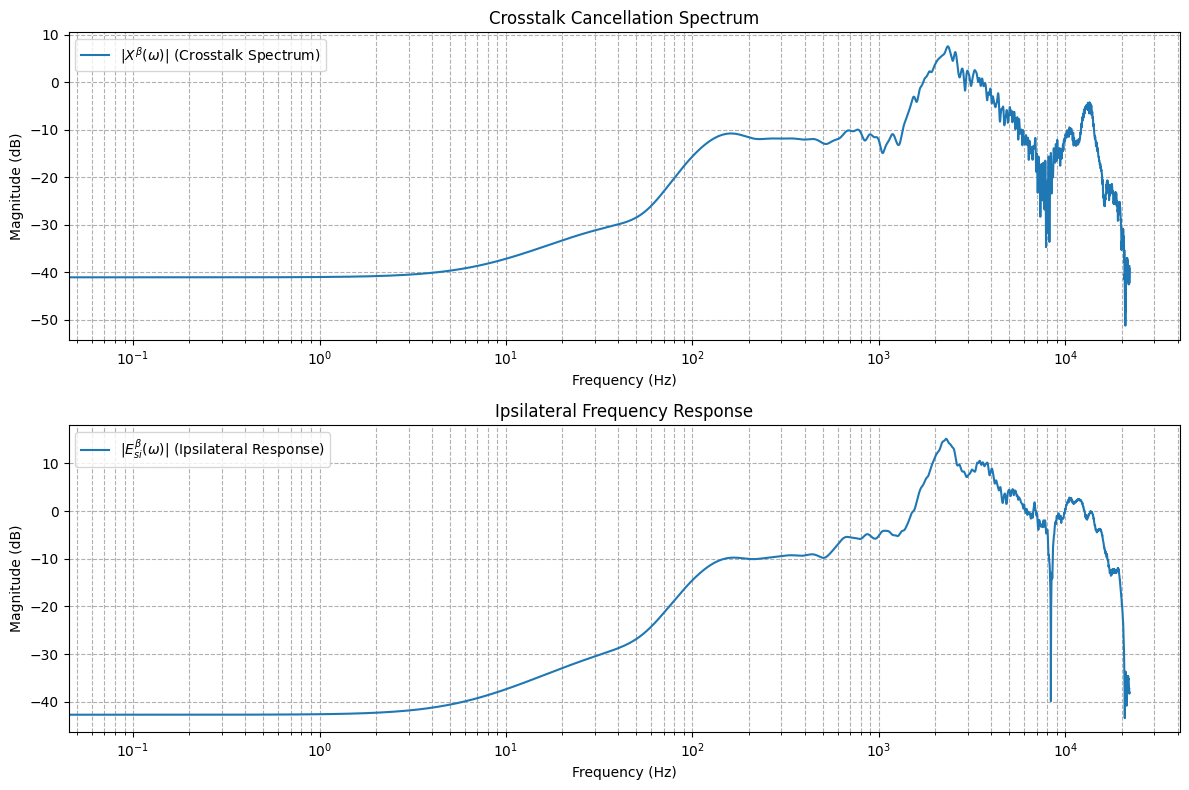

In [ ]:
# Regularization
beta = 0.01

# Apply regularization to HRTFs
H_LL_reg = H_LL_f + beta
H_LR_reg = H_LR_f + beta
H_RL_reg = H_RL_f + beta
H_RR_reg = H_RR_f + beta

# Compute crosstalk spectrum
Crosstalk_Spectrum = 20 * np.log10(np.abs(H_LR_reg) + epsilon)

# Compute (ipsilateral response for the left ear)
Ipsilateral_Response = 20 * np.log10(np.abs(H_LL_reg) + epsilon)

freqs = np.fft.fftfreq(N, d=1/fs)
positive_freqs = freqs[:N // 2]

# Extract positive frequencies and corresponding responses
Crosstalk_Spectrum_Pos = Crosstalk_Spectrum[:N // 2]
Ipsilateral_Response_Pos = Ipsilateral_Response[:N // 2]


plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.semilogx(positive_freqs, Crosstalk_Spectrum_Pos, label=r'$|X^\beta(\omega)|$ (Crosstalk Spectrum)')
plt.title('Crosstalk Cancellation Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True, which='both', linestyle='--')

plt.subplot(2, 1, 2)
plt.semilogx(positive_freqs, Ipsilateral_Response_Pos, label=r'$|E_{si}^\beta(\omega)|$ (Ipsilateral Response)')
plt.title('Ipsilateral Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True, which='both', linestyle='--')

plt.tight_layout()
plt.show()


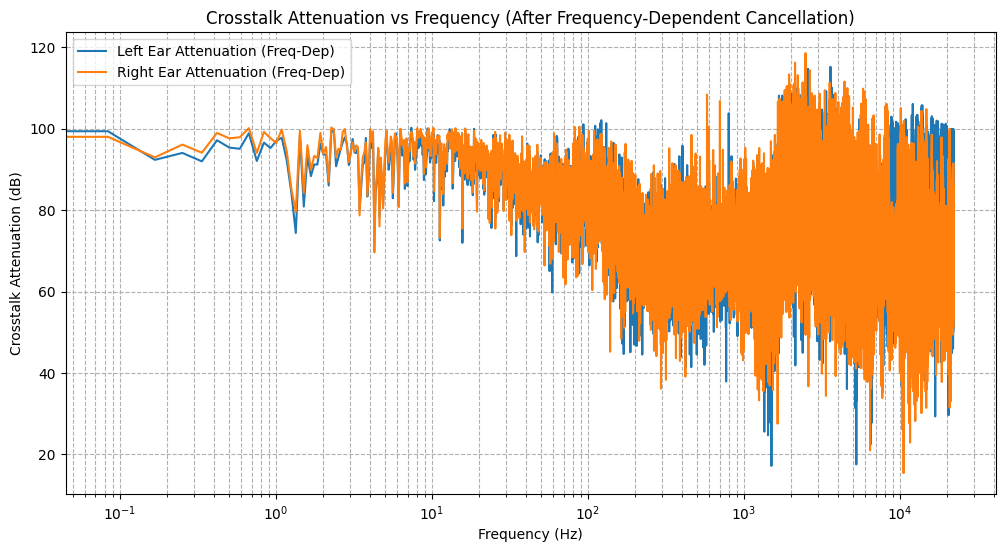

In [ ]:
# Compute FFTs of the desired ear signals padded to length N
L_f = np.fft.fft(L_desired, n=N)
R_f = np.fft.fft(R_desired, n=N)

# Stack HRTFs into arrays (shape: N x 2 x 2)
H_f = np.zeros((N, 2, 2), dtype=complex)
H_f[:, 0, 0] = H_LL_f
H_f[:, 0, 1] = H_LR_f
H_f[:, 1, 0] = H_RL_f
H_f[:, 1, 1] = H_RR_f

# Stack desired ear signals (shape: N x 2)
Desired_f = np.stack((L_f, R_f), axis=1)

# Initialize array for loudspeaker signals
S_f = np.zeros_like(Desired_f, dtype=complex)

# Frequency vector
freqs = np.fft.fftfreq(N, d=1/fs)

# Regularization constant
gamma = 0.0005

# Perform frequency-dependent crosstalk cancellation
for n in range(N):
    # Extract H at frequency bin n
    H = H_f[n, :, :]  # Shape: 2 x 2
    HHH = H.conj().T @ H
    U, s, Vh = svd(HHH)
    lambda_f = gamma * np.min(s)
    Inv = np.linalg.inv(HHH + lambda_f * np.eye(2)) @ H.conj().T
    S_f[n, :] = Inv @ Desired_f[n, :]

S_L = np.fft.ifft(S_f[:, 0]).real[:len(L_desired)]
S_R = np.fft.ifft(S_f[:, 1]).real[:len(R_desired)]

def simulate_ear_signals_no_cancellation(L_desired, R_desired, H_LL, H_LR, H_RL, H_RR):
    # Convolve desired signals with HRTFs
    Ear_L_before = fftconvolve(L_desired, H_LL, mode='full')[:len(L_desired)] + \
                   fftconvolve(R_desired, H_LR, mode='full')[:len(L_desired)]
    Ear_R_before = fftconvolve(L_desired, H_RL, mode='full')[:len(L_desired)] + \
                   fftconvolve(R_desired, H_RR, mode='full')[:len(L_desired)]
    return Ear_L_before, Ear_R_before

def simulate_ear_signals_with_cancellation(S_L, S_R, H_LL, H_LR, H_RL, H_RR):
    # Convolve processed signals with HRTFs
    Ear_L_after = fftconvolve(S_L, H_LL, mode='full')[:len(S_L)] + \
                  fftconvolve(S_R, H_LR, mode='full')[:len(S_L)]
    Ear_R_after = fftconvolve(S_L, H_RL, mode='full')[:len(S_L)] + \
                  fftconvolve(S_R, H_RR, mode='full')[:len(S_L)]
    return Ear_L_after, Ear_R_after

# Compute crosstalk levels
def compute_crosstalk_levels(Ear_L, Ear_R, L_desired, R_desired):
    # Align lengths
    min_len = min(len(Ear_L), len(L_desired))
    Ear_L = Ear_L[:min_len]
    Ear_R = Ear_R[:min_len]
    L_desired = L_desired[:min_len]
    R_desired = R_desired[:min_len]

    Desired_L = L_desired
    Desired_R = R_desired

    Crosstalk_L = Ear_L - Desired_L
    Crosstalk_R = Ear_R - Desired_R

    # Compute power of signals
    Power_Desired_L = np.sum(Desired_L ** 2)
    Power_Crosstalk_L = np.sum(Crosstalk_L ** 2)

    Power_Desired_R = np.sum(Desired_R ** 2)
    Power_Crosstalk_R = np.sum(Crosstalk_R ** 2)

    CTR_L = 10 * np.log10(Power_Crosstalk_L / Power_Desired_L + epsilon)
    CTR_R = 10 * np.log10(Power_Crosstalk_R / Power_Desired_R + epsilon)

    return CTR_L, CTR_R
Ear_L_after_f_freq, Ear_R_after_f_freq = simulate_ear_signals_freq(S_f[:, 0], S_f[:, 1], H_LL_f, H_LR_f, H_RL_f, H_RR_f)

CTR_L_after_freq_dep, CTR_R_after_freq_dep = compute_crosstalk_levels_freq(
    Ear_L_after_f_freq,
    Ear_R_after_f_freq,
    L_f,
    R_f
)

Crosstalk_Attenuation_L_freq_dep = CTR_L_before_freq - CTR_L_after_freq_dep
Crosstalk_Attenuation_R_freq_dep = CTR_R_before_freq - CTR_R_after_freq_dep

positive_freqs = freqs[:N//2]
Attenuation_L_positive_fd = Crosstalk_Attenuation_L_freq_dep[:N//2]
Attenuation_R_positive_fd = Crosstalk_Attenuation_R_freq_dep[:N//2]

plt.figure(figsize=(12, 6))
plt.semilogx(positive_freqs, Attenuation_L_positive_fd, label='Left Ear Attenuation (Freq-Dep)')
plt.semilogx(positive_freqs, Attenuation_R_positive_fd, label='Right Ear Attenuation (Freq-Dep)')
plt.title('Crosstalk Attenuation vs Frequency (After Frequency-Dependent Cancellation)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Crosstalk Attenuation (dB)')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()

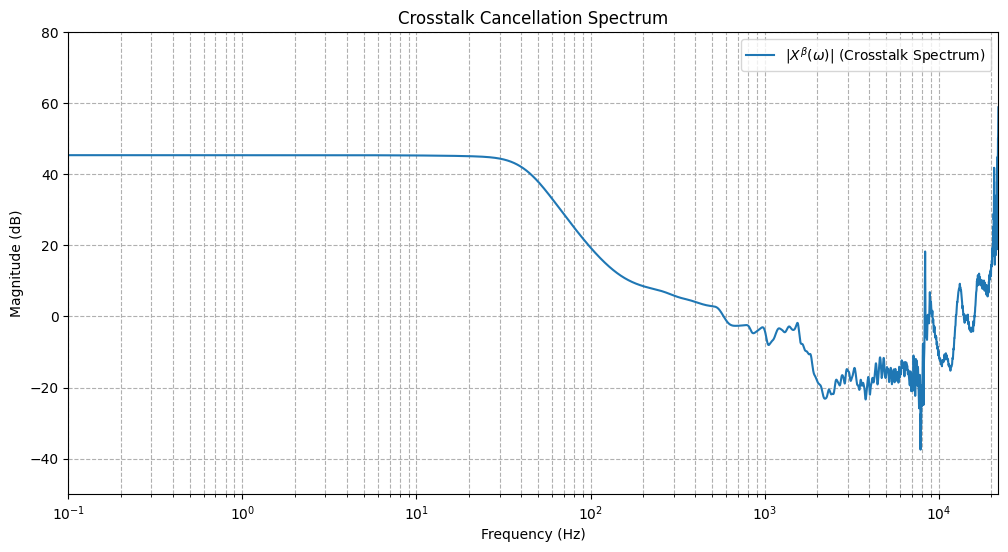

In [ ]:
# Compute the frequency response of the crosstalk cancellation filter
def compute_filter_response(H_f, gamma):
    N = H_f.shape[0]
    filter_response = np.zeros(N, dtype=complex)

    for n in range(N):
        H = H_f[n, :, :]
        HHH = H.conj().T @ H
        U, s, Vh = svd(HHH)
        lambda_f = gamma * np.min(s)
        Inv = np.linalg.inv(HHH + lambda_f * np.eye(2)) @ H.conj().T

        # Use the cross-talk component (off-diagonal term)
        filter_response[n] = Inv[0, 1]  # Left-to-right crosstalk cancellation

    return filter_response

filter_response = compute_filter_response(H_f, gamma)
magnitude_response = 20 * np.log10(np.abs(filter_response) + epsilon)

plt.figure(figsize=(12, 6))
plt.semilogx(freqs[:N//2], magnitude_response[:N//2],
             label=r'$|X^\beta(\omega)|$ (Crosstalk Spectrum)')
plt.title('Crosstalk Cancellation Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True, which='both', linestyle='--')
plt.xlim([10**-1, fs/2])
plt.ylim([-50, 80])
plt.legend()
plt.show()


<ipython-input-7-ccd42437baf0>:3: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((g**2 - 2*gamma**2 + 1)/(2*g))


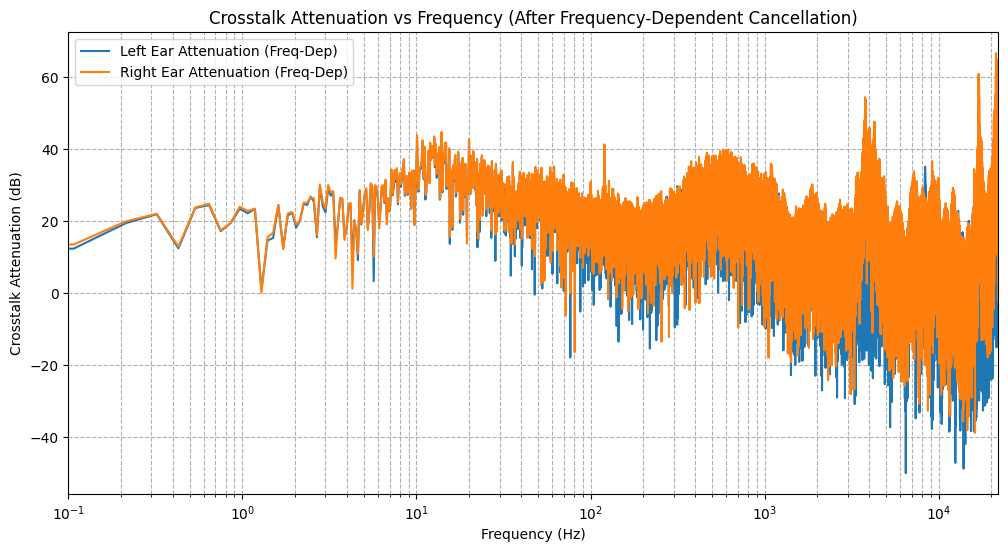

In [ ]:
def calculate_band_bounds(g, gamma_db):
    gamma = 10**(gamma_db/20)
    theta = np.arccos((g**2 - 2*gamma**2 + 1)/(2*g))

    # Calculate frequency bounds for first 8 bands (n=0,1)
    bounds = []
    for n in range(2):  # For first 8 bands
        # Branch I bounds (4n+1)
        bounds.append((2*n*np.pi, 2*n*np.pi + theta))
        # Branch P bounds (4n+2)
        bounds.append((2*n*np.pi + theta, (2*n+1)*np.pi))
        # Branch II bounds (4n+3)
        bounds.append(((2*n+1)*np.pi, (2*n+1)*np.pi + theta))
        # Branch P bounds (4n+4)
        bounds.append(((2*n+1)*np.pi + theta, 2*(2*n+1)*np.pi))

    return np.array(bounds)

def compute_regularization_parameters(omega_c, g, gamma_db):
    gamma = 10**(gamma_db/20)
    x = 2*g*np.cos(omega_c)
    lambda_I = np.sqrt((g**2 + 2*g*np.cos(omega_c) + 1)/(g**2 - 2*g*np.cos(omega_c) + 1)) - 1
    lambda_II = np.sqrt((g**2 - 2*g*np.cos(omega_c) + 1)/(g**2 + 2*g*np.cos(omega_c) + 1)) - 1

    return lambda_I, lambda_II

def optimized_crosstalk_cancellation(H_f, g=0.985, gamma_db=7):
    N = H_f.shape[0]
    S_f = np.zeros((N, 2), dtype=complex)  # Changed shape to (N, 2)

    # frequency vector in radians!!!!
    omega_c = 2 * np.pi * np.fft.fftfreq(N)

    bounds = calculate_band_bounds(g, gamma_db)

    for n in range(N):
        H = H_f[n, :, :]
        HHH = H.conj().T @ H
        U, s, Vh = svd(HHH)

        # Determine which branch this frequency belongs to
        current_omega = np.abs(omega_c[n]) % (2*np.pi)

        # Find which band the frequency belongs to
        for i, (lower, upper) in enumerate(bounds):
            if lower <= current_omega <= upper:
                band_type = i % 4  # 0:Branch I, 1:Branch P, 2:Branch II, 3:Branch P
                break
        else:
            band_type = 3  # Default to Branch P

        if band_type == 0:  # Branch I
            lambda_I, _ = compute_regularization_parameters(omega_c[n], g, gamma_db)
            reg_param = lambda_I
        elif band_type == 2:  # Branch II
            _, lambda_II = compute_regularization_parameters(omega_c[n], g, gamma_db)
            reg_param = lambda_II
        else:  # Branch P
            reg_param = 0

        # Apply regularization
        if reg_param > 0:
            Inv = np.linalg.inv(HHH + reg_param * np.eye(2)) @ H.conj().T
        else:
            Inv = np.linalg.pinv(H)

        # Store the computed filter values - This was missing
        S_f[n, 0] = Inv[0, 0] * L_f[n] + Inv[0, 1] * R_f[n]
        S_f[n, 1] = Inv[1, 0] * L_f[n] + Inv[1, 1] * R_f[n]

    return S_f[:, 0], S_f[:, 1]


S_L_f, S_R_f = optimized_crosstalk_cancellation(H_f, g=0.5, gamma_db=5)
S_L = np.fft.ifft(S_L_f).real[:len(L_desired)]
S_R = np.fft.ifft(S_R_f).real[:len(R_desired)]

def simulate_ear_signals_no_cancellation_freq(L_desired_f, R_desired_f, H_LL_f, H_LR_f, H_RL_f, H_RR_f):
    # Ear signals without crosstalk cancellation in frequency domain
    Ear_L_before_f = H_LL_f * L_desired_f + H_LR_f * R_desired_f
    Ear_R_before_f = H_RL_f * L_desired_f + H_RR_f * R_desired_f
    return Ear_L_before_f, Ear_R_before_f

def simulate_ear_signals_freq(S_L_f, S_R_f, H_LL_f, H_LR_f, H_RL_f, H_RR_f):
    # Ear signals after crosstalk cancellation in frequency domain
    Ear_L_f = H_LL_f * S_L_f + H_LR_f * S_R_f
    Ear_R_f = H_RL_f * S_L_f + H_RR_f * S_R_f
    return Ear_L_f, Ear_R_f

def compute_crosstalk_levels_freq(Ear_L_f, Ear_R_f, L_desired_f, R_desired_f, epsilon=1e-10):
    PSD_Desired_L = np.abs(L_desired_f)**2
    PSD_Desired_R = np.abs(R_desired_f)**2

    Crosstalk_L_f = Ear_L_f - L_desired_f
    Crosstalk_R_f = Ear_R_f - R_desired_f

    PSD_Crosstalk_L = np.abs(Crosstalk_L_f)**2
    PSD_Crosstalk_R = np.abs(Crosstalk_R_f)**2

    CTR_L = 10 * np.log10(PSD_Crosstalk_L / (PSD_Desired_L + epsilon) + epsilon)
    CTR_R = 10 * np.log10(PSD_Crosstalk_R / (PSD_Desired_R + epsilon) + epsilon)

    return CTR_L, CTR_R

N = len(L_desired)
L_f = np.fft.fft(L_desired, n=N)
R_f = np.fft.fft(R_desired, n=N)
H_LL_f = np.fft.fft(H_LL, n=N)
H_LR_f = np.fft.fft(H_LR, n=N)
H_RL_f = np.fft.fft(H_RL, n=N)
H_RR_f = np.fft.fft(H_RR, n=N)


Ear_L_before_f, Ear_R_before_f = simulate_ear_signals_no_cancellation_freq(L_f, R_f, H_LL_f, H_LR_f, H_RL_f, H_RR_f)
CTR_L_before_freq, CTR_R_before_freq = compute_crosstalk_levels_freq(Ear_L_before_f, Ear_R_before_f, L_f, R_f)

S_L_f = np.fft.fft(S_L, n=N)
S_R_f = np.fft.fft(S_R, n=N)

Ear_L_after_f, Ear_R_after_f = simulate_ear_signals_freq(S_L_f, S_R_f, H_LL_f, H_LR_f, H_RL_f, H_RR_f)
CTR_L_after_freq, CTR_R_after_freq = compute_crosstalk_levels_freq(Ear_L_after_f, Ear_R_after_f, L_f, R_f)

Crosstalk_Attenuation_L_freq = CTR_L_before_freq - CTR_L_after_freq
Crosstalk_Attenuation_R_freq = CTR_R_before_freq - CTR_R_after_freq

freqs = np.fft.fftfreq(N, d=1/fs)
positive_freqs = freqs[:N//2]
Attenuation_L_positive = Crosstalk_Attenuation_L_freq[:N//2]
Attenuation_R_positive = Crosstalk_Attenuation_R_freq[:N//2]

plt.figure(figsize=(12, 6))
plt.semilogx(positive_freqs, Attenuation_L_positive, label='Left Ear Attenuation (Freq-Dep)')
plt.semilogx(positive_freqs, Attenuation_R_positive, label='Right Ear Attenuation (Freq-Dep)')
plt.title('Crosstalk Attenuation vs Frequency (After Frequency-Dependent Cancellation)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Crosstalk Attenuation (dB)')
plt.grid(True, which='both', linestyle='--')
plt.xlim([10**-1, fs/2])
plt.legend()
plt.show()


<ipython-input-16-f699fce02a07>:3: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((g**2 - 2*gamma**2 + 1)/(2*g))


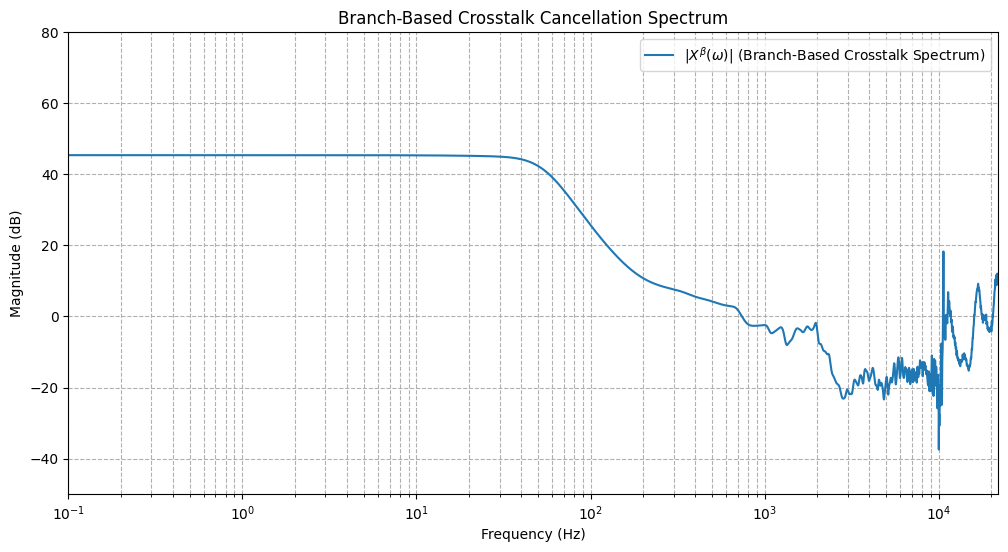

In [ ]:
def compute_branch_based_filter_response(H_f, fs, g=0.985, gamma_db=7, epsilon=1e-10):
    N = H_f.shape[0]
    omega_c = 2 * np.pi * np.fft.fftfreq(N, d=1/fs)
# Compute band bounds for branch determination
    bounds = calculate_band_bounds(g, gamma_db)
# Initialize the filter response array
    filter_response = np.zeros(N, dtype=complex)

    for n in range(N):
        H = H_f[n, :, :]
        HHH = H.conj().T @ H
        U, s, Vh = svd(HHH)

        current_omega = np.abs(omega_c[n]) % (2 * np.pi)
        band_type = 3  # default to Branch P if not found
        for i, (lower, upper) in enumerate(bounds):
            if lower <= current_omega <= upper:
                band_type = i % 4
                break

        if band_type == 0:
            lambda_I, _ = compute_regularization_parameters(omega_c[n], g, gamma_db)
            reg_param = lambda_I
        elif band_type == 2:
            _, lambda_II = compute_regularization_parameters(omega_c[n], g, gamma_db)
            reg_param = lambda_II
        else:
            reg_param = 0

        if reg_param > 0:
            Inv = np.linalg.inv(HHH + reg_param * np.eye(2)) @ H.conj().T
        else:
            # If no regularization, use pseudo-inverse
            Inv = np.linalg.pinv(H)

        # Extract the off-diagonal term Inv[0,1] for crosstalk cancellation filter response
        filter_response[n] = Inv[0, 1]

    return filter_response


filter_response = compute_branch_based_filter_response(H_f, fs, g=0.985, gamma_db=7, epsilon=1e-10)


freqs = np.fft.fftfreq(N, d=1/fs)
magnitude_response = 20 * np.log10(np.abs(filter_response) + epsilon)

positive_freqs = freqs[:N//2]
positive_magnitude = magnitude_response[:N//2]

plt.figure(figsize=(12, 6))
plt.semilogx(positive_freqs, positive_magnitude, label=r'$|X^\beta(\omega)|$ (Branch-Based Crosstalk Spectrum)')
plt.title('Branch-Based Crosstalk Cancellation Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True, which='both', linestyle='--')
plt.xlim([10**-1, fs/2])
plt.ylim([-50, 80])
plt.legend()
plt.show()


In [ ]:
import soundfile as sf

def normalize(signal):
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        return signal / max_val
    else:
        return signal

S_L_norm = normalize(S_L)
S_R_norm = normalize(S_R)

sf.write('loudspeaker_signals_freq.wav', np.vstack((S_L_norm, S_R_norm)).T, samplerate=44100)

